MNIST-CNN library

In [1]:
import sys

import requests
import numpy as np
np.random.seed(42)

import pandas as pd
import os
import idx2numpy
import gzip
import torch
torch.manual_seed(42)

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as  nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import mnist_downloader as md
import dataloader as dl
import model
import trainer
import visualiser

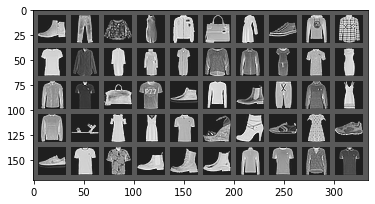

In [2]:
#Get MNIST data from MNIST-dataloader
(trainys,trainxs, validys, validxs, testys, testxs) = md.mnist_downloader()

#Set batch size
BATCH_SIZE = 50

#Create datasets using custom dataloader
dataset_loader = dl.Custom_Dataset_Loader(batch_size=BATCH_SIZE)

train_set_loader = dataset_loader.create_dataset_loader(trainxs,trainys, train=True)
valid_set_loader = dataset_loader.create_dataset_loader(validxs, validys, train=False)
test_set_loader = dataset_loader.create_dataset_loader(trainxs,trainys, train=False)

# Load a batch of training images for visualising
data_iterator = iter(train_set_loader)
images, labels = data_iterator.next()

#Function for visualisation
def show_image(img, train_std, train_mean):
    # De-normalise & convert to numpy, plot
    img = img * train_std + train_mean
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Plot images as a grid using the 'make_grid' function
show_image(torchvision.utils.make_grid(images,10,5), dataset_loader.train_mean
           ,dataset_loader.train_std)
plt.show();

### Model Training

Inititating 2-layer conv net
     First layer kernel-size: 5, no. channels: 10
     Second layer kernel-size: 5, no.channels: 20
Commencing training


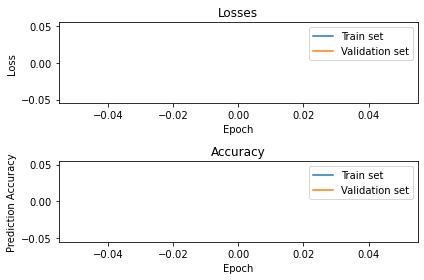

In [11]:
net = model.two_layer_conv_net(channel1=10, channel2=20, kernel1=5, kernel2=5)

if torch.cuda.is_available():
    net.cuda()
    
Trainer = trainer.Trainer(net, learning_rate = 0.0005)
Trainer.train_net(train_set_loader
              ,valid_set_loader
              , max_epochs = 0)
Trainer.show_results()
# trainer.eval_on_test_set(test_set_loader)

Visualiser = visualiser.visualiser(net)
# visualiser.visualise_conv_filters()

#Get a random image to visualise
(batchid, (example_data, example_labels)) = next(enumerate(test_set_loader))

#Process for passing through the conv layers
img = example_data[10].float()
img.unsqueeze_(0)
img = Variable(img, requires_grad = False)

Displaying example image used to calculate activations


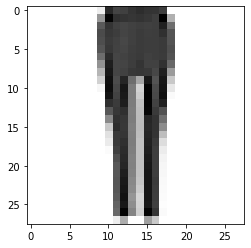


Displaying first layer activations



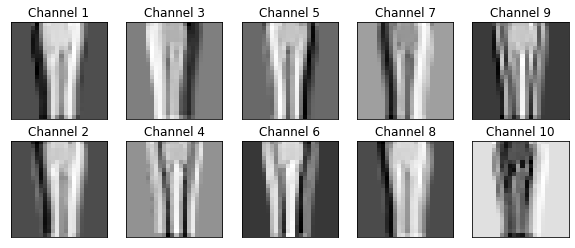


Displaying second layer activations



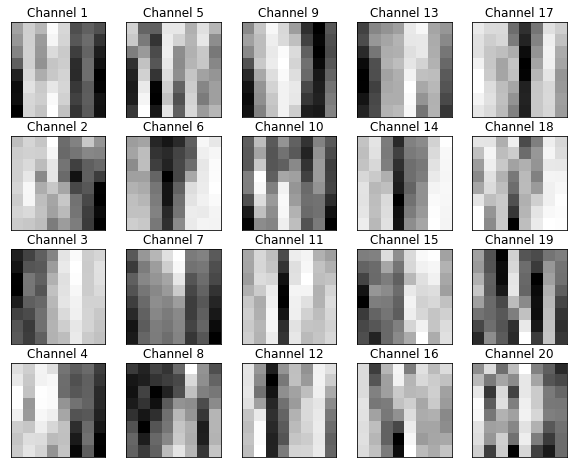

In [12]:
print('Displaying example image used to calculate activations')
plt.imshow(img[0,0,:,:], cmap='Greys')
plt.show()

#Display activation
Visualiser.visualise_conv_activations(img)

### Confusion Matrix


Full confusion matrix (on validation set)




,0,1,2,3,4,5,6,7,8,9
0,0,,,,6,0,,,1017,
1,5,,,,0,1,,,982,
2,22,,,,17,0,,,969,
3,5,,,,8,0,,,1008,
4,24,,,,18,0,,,1008,
5,122,,,,258,29,,,587,
6,13,,,,15,0,,,942,
7,51,,,,403,17,,,484,
8,46,,,,238,10,,,674,
9,1,,,,116,44,,,860,




Graphical representation - misclassifications only




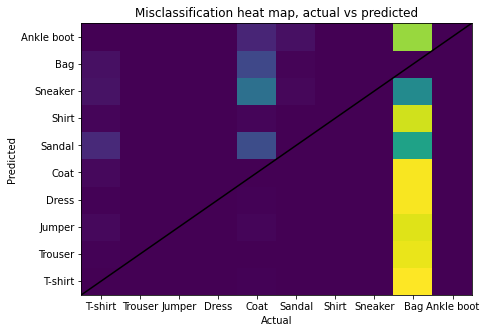

In [13]:
lst = np.array(["T-shirt", "Trouser", "Jumper", "Dress", "Coat"
      ,"Sandal","Shirt","Sneaker","Bag","Ankle boot"])

conf_matrix = torch.zeros(10,10)

#Predicted is y
#Actual is x axis
#[0,0] is top left
for valid_data in valid_set_loader:
    valid_images, valid_labels = valid_data
    valid_labels = valid_labels.long()
    
    #Get net outputs
    outputs = net.forward(Variable(valid_images).float())

    #Accuracy calc
    pred_labels = torch.argmax(outputs, 1)
    pred_labels = pred_labels.view(-1,1)
    
    for (x, y ) in zip(valid_labels, pred_labels):
        conf_matrix[x,y] += 1

#Send to numpy
conf_matrix = conf_matrix.numpy()

#Create dataframe
pd.set_option('precision', 0)
conf_matrix_df = pd.DataFrame(conf_matrix)
print('\nFull confusion matrix (on validation set)\n\n')
display(conf_matrix_df)

#Transform to percentages
conf_matrix = 100 * conf_matrix / np.sum(conf_matrix,axis=1)
conf_matrix = np.round(conf_matrix, 2)

#Remove the leading diagonal to leave miscalssifications only
norm_conf = conf_matrix * (np.ones((10,10)) - np.eye(10))

#Plot misclassifications
print('\n\nGraphical representation - misclassifications only\n\n')
plt.rcParams["figure.figsize"] = (7,5)
plt.pcolor(norm_conf)
plt.title('Misclassification heat map, actual vs predicted')
plt.plot(np.arange(11), np.arange(11), color='black')
plt.xticks(np.arange(10)+0.5, lst)
plt.yticks(np.arange(10)+0.5, lst)
plt.ylabel("Predicted"); plt.xlabel("Actual");

### Results Analysis

In [14]:
#Create dataframe of the most common misclassification
pd.set_option('precision', 2)
pd.DataFrame({'Actual label':lst , 
              "Percentage correctly classified": np.max(conf_matrix, axis = 1),
              "Most likely misclassification": lst[np.argmax(norm_conf, axis = 1)],
             "Percentage misclassified": np.max(norm_conf, axis = 1)})

,Actual label,Percentage correctly classified,Most likely misclassification,Percentage misclassified
0,T-shirt,105.06,Bag,105.06
1,Trouser,101.45,Bag,101.45
2,Jumper,100.10,Bag,100.10
3,Dress,104.13,Bag,104.13
4,Coat,104.13,Bag,104.13
5,Sandal,60.64,Bag,60.64
6,Shirt,97.31,Bag,97.31
7,Sneaker,50.00,Bag,50.00
8,Bag,69.63,Coat,22.67
9,Ankle boot,88.84,Bag,88.84
